In [1]:
import os, json
import numpy as np
from shapely.geometry import Polygon, shape, Point
from dateutil import parser
from map_parsing import Territory
from tqdm.notebook import tqdm
from datetime import datetime
from drawing_utils import draw_territories, draw_plain, draw_contour
import matplotlib.pyplot as plt

class TimedTerritory(Territory)  :
    def __init__(self, color, polygon, start, end):
        super().__init__( color, polygon)
        assert isinstance(start, datetime)
        assert isinstance(end, datetime)
        self.start=start
        self.end=end
    
    def valid_in(self, date):
        assert isinstance(date, datetime)
        return self.start<= date and self.end > date
    def contemporary_with(self, other):
        assert isinstance(other, TimedTerritory)
        return self.start < other.end and self .end > other.start

def load_timed_territories(filename):
    data = json.load(open(filename, 'r'))
    return [TimedTerritory(datum['color'], shape(datum['polygon']), parser.parse(datum['start']), parser.parse(datum['end'])) for datum in data]

territories =  load_timed_territories(f'../tmp/time_contiguous_territories/all_territories.json')
black = np.zeros((1080,1920,3))

territories_in_1816 = [t for t in territories if t.valid_in(parser.parse('1816-01-01T00:00.000Z'))]

draw_territories(black, (territories_in_1816, 'fill', None))

<Figure size 1440x1280 with 1 Axes>

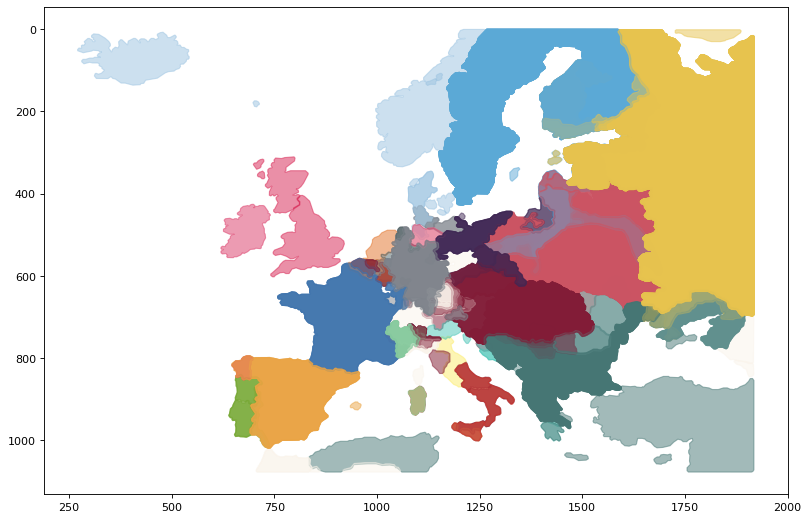

In [2]:
from shapely.geometry import box, LineString
import mpld3
import random
%matplotlib inline
mpld3.enable_notebook()


europe_fat = [TimedTerritory(t.color, t.polygon.buffer(2), t.start, t.end) for t in territories]
for t in europe_fat:
    if len(t.polygon.interiors):
        t.polygon = Polygon(t.polygon.exterior)


def _innerDrawPaul(obj, i , color=None, simplify=None):
    try :
        if isinstance(obj, Polygon) or isinstance(obj, LineString):
            if simplify:
                obj=obj.simplify(1)
            color =  color if color is not None else [ 'g', 'r', 'c', 'm', 'y', 'k'][i%6]
        if isinstance(obj, Polygon):
            plt.fill(*obj.exterior.xy, color=color, alpha=.5)
        elif isinstance(obj, LineString):
            if not obj.empty:
                plt.plot(*obj.xy, color=color)
        elif isinstance(obj, tuple):
            _innerDrawPaul(obj[0], i, obj[1], simplify)
        elif isinstance(obj, Territory):
            _innerDrawPaul(obj.polygon, i, obj.color, simplify)
        elif isinstance(obj, MultiPolygon):
            _innerDrawPaul(GeometryCollection(obj.geoms), color, simplify)
        elif isinstance(obj, Point):
            _innerDrawPaul(obj.buffer(.1), i, color, simplify)
        elif isinstance(obj, MultiPoint):
            _innerDrawPaul(obj.buffer(.1), i, color, simplify)
        elif isinstance(obj, GeometryCollection):
            for sub_object in obj:
                _innerDrawPaul(sub_object, i, color, simplify)
        else:
            raise TypeError(f'Unknown type : {type(obj)}')
    except Exception as e :
        print('Error plotting : ', obj)
        raise e

def drawPaul(*objects, simplify=False):
    ax = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k').add_subplot()
    ax.set_aspect(aspect='equal')
    for i, o in tqdm(enumerate(objects),total=len(objects), leave=False):
        _innerDrawPaul(o, i, simplify=simplify)
    plt.gca().invert_yaxis()
    
    plt.show()


drawPaul(*europe_fat[:300], simplify=True)


190
95


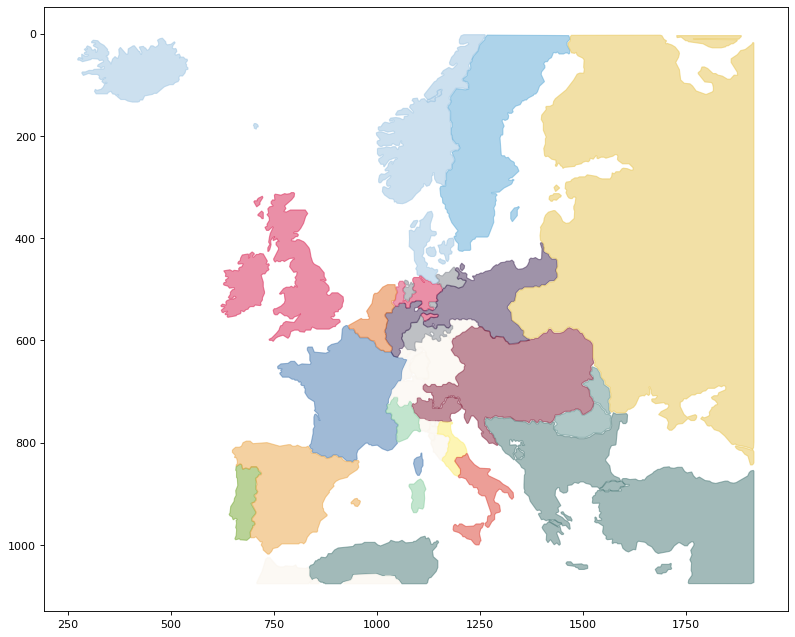

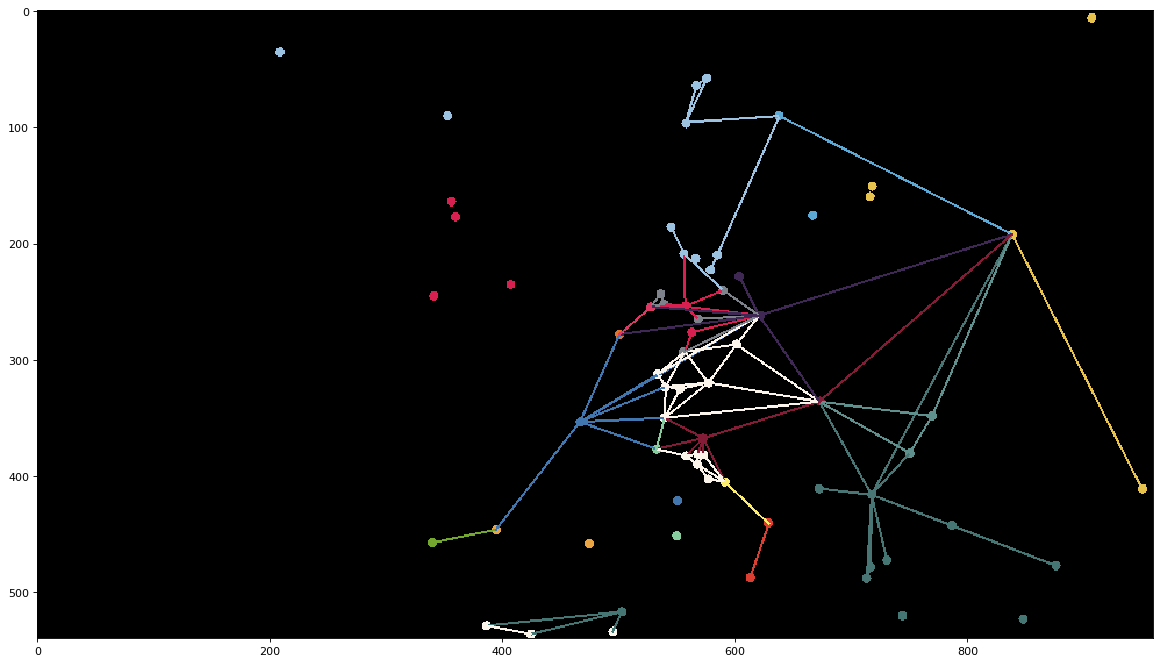

In [5]:
from drawing_utils import display_img

def get_circle(terr):
    return terr.centroid.buffer(8)

def get_line(terra, terrb):
    return LineString([terra.polygon.centroid, terrb.polygon.centroid])

def draw_graph(nodes_desc, arcs_desc):
    res = black[::2, ::2].copy()
    for node, color in tqdm(nodes_desc):
        res = draw_plain(res, node.buffer(8), color, False, True)
    for line, color in arcs_desc:
        res = draw_plain(res, line.buffer(2), color, False, True)
    return res


print(len(stuck_pols))
stuck_pols_unique = []
for a,b,athin,bthin in stuck_pols:
    if (b,a,bthin,athin) not in stuck_pols_unique:
        stuck_pols_unique.append((a,b, athin, bthin))
print(len(stuck_pols_unique))

arcs_desc = [(get_line(a,b), a.color) for a,b,_,_ in stuck_pols_unique]
graph_img = draw_graph([(terr.polygon.centroid, terr.color) for terr in territories_in_1816], arcs_desc)

drawPaul(*territories_in_1816, simplify=True)
display_img(graph_img)


In [4]:
from shapely.geometry import MultiPolygon, MultiLineString, MultiPoint, Point, GeometryCollection
import shapely.affinity
import shapely.ops
import copy

def draw_zoom_territories(terra, terrb, intersection_pols=[]):
    
    xa,ya,xb,yb= np.array(MultiPolygon((terra.polygon, terrb.polygon)).bounds).astype(int)
    translatedA = shapely.affinity.translate(terra.polygon, -xa, -ya)
    translatedB = shapely.affinity.translate(terrb.polygon, -xa, -ya)
    intersection_pols = copy.deepcopy(intersection_pols)
    for i in range(len(intersection_pols)) :
        for j in range(len(intersection_pols[i])):
            intersection_pols[i][j] = shapely.affinity.translate(intersection_pols[i][j], -xa, -ya)
    if not intersection_pols: 
        draw_territories(np.zeros((yb -ya, xb-xa, 3)), 
                 (translatedA, 'fill', terra.color), 
                 (translatedB, 'fill', terrb.color), 
                )
    elif len(intersection_pols[0]) == 3:
        draw_territories(np.zeros((yb -ya, xb-xa, 3)), 
                 (translatedA, 'fill', terra.color), 
                 (translatedB, 'fill', terrb.color), 
                 (MultiLineString([inter_data[0] for inter_data in intersection_pols]).buffer(.001), 'stroke', 'red'),
                 (intersection_pols[0][1].buffer(.001), 'stroke', 'white'),
                 (intersection_pols[0][2].buffer(.001), 'stroke', 'blue'),
                )
    elif len(intersection_pols[0]) == 4:
        print(intersection_pols[0][1])
        draw_territories(np.zeros((yb -ya, xb-xa, 3)), 
                 (translatedA, 'fill', terra.color), 
                 (translatedB, 'fill', terrb.color), 
                 #(MultiLineString([inter_data[0] for inter_data in intersection_pols]).buffer(.001), 'stroke', 'red'),
                 (MultiPolygon([inter_data[1] for inter_data in intersection_pols]), 'stroke', 'white'),
                 (MultiPolygon([inter_data[2] for inter_data in intersection_pols]), 'stroke', 'white'),
                 #(MultiLineString([inter_data[3] for inter_data in intersection_pols]).buffer(.001), 'stroke', 'white'),
                )
    elif len(intersection_pols[0]) == 1:
        draw_territories(np.zeros((yb -ya, xb-xa, 3)), 
                 (translatedA, 'fill', terra.color), 
                 (translatedB, 'fill', terrb.color), 
                 (MultiLineString([inter_data[0] for inter_data in intersection_pols]).buffer(.001), 'stroke', 'red'),
                )
class DonutException(Exception):
    pass

def get_intersections_data(terra, terrb):
    res = []
    intersections = terra.polygon.intersection(terrb.polygon)
    if not isinstance(intersections, MultiPolygon):
        intersections=MultiPolygon([intersections])
    for intersection in intersections:
        extremities = terrb.polygon.boundary.intersection(terra.polygon.boundary).intersection(intersection)
        if len(extremities) < 2:
            raise DonutException('Less than 2 extremities, probably donut')
            
        splitted = shapely.ops.split(intersection.boundary, extremities[0])
        if len(splitted) > 2:
            raise Exception(f'splitted is size {len(splitted)}')
        elif len(splitted)>1:
            splitted = LineString(list(splitted[1].coords) + list(splitted[0].coords))
        else:
            splitted = splitted[0]
        try :
            splitted = shapely.ops.split(splitted, extremities)
        except ValueError as e :
            print(splitted)
            raise e
        if len(splitted) != 2:
            drawPaul(terra, terrb)
            drawPaul(intersection, terra)
            drawPaul(intersection, terrb)
            
            print(f'Splitted is size {len(splitted)} after cut with {len(extremities)} extremities : {shapely.affinity.translate(extremities, -intersection.bounds[0],- intersection.bounds[1])}')
            #print(f'intersection  {intersection}')
            print(f'''
                Validity : 
                terra polygon : {terra.polygon.is_valid}
                terrb polygon : {terrb.polygon.is_valid}
                intersection : {intersection.is_valid}
            ''')
            #draw_zoom_territories(terra, terrb, [[intersection.boundary]])
            raise Exception()
        ordered = LineString(splitted[1].coords[::-1])
        if(ordered.coords[0] != splitted[0].coords[0]):
            print(splitted[0].coords[0])
            print(ordered.coords[0])
            raise Exception()
        
        segA, segB = (splitted[0], ordered) if len(splitted[0].coords) > len(ordered.coords) else (ordered, splitted[0])
        nbPtA, nbPtB = len(segA.coords), len(segB.coords)
        midSegA = []
        for i in range(nbPtA):
            pta = Point(segA.coords[i])
            ptb = segB.interpolate(segB.project(pta))
            middle_point = middlePoint(pta, ptb)
            if is_consistent_middle_point(Point(middle_point), segA, segB):
                midSegA.append(middle_point)
        midSegB = []
        for i in range(nbPtB):
            ptb = Point(segB.coords[i])
            pta = segA.interpolate(segA.project(ptb))
            middle_point = middlePoint(pta, ptb)
            if is_consistent_middle_point(Point(middle_point), segA, segB):
                midSegB.append(middle_point)
        midSeg = linkPoints(midSegA, midSegB)
        if not midSeg.is_simple:
            midSeg = midSegA
        midSeg = LineString(midSeg)
        assert midSeg.is_simple
        res.append([segA, segB, midSeg])
    return res

def is_consistent_middle_point(point, sega, segb):
    dista = sega.distance(point)
    distb = segb.distance(point)
    try :
        ratio = min(dista, distb)/(dista+distb)
        return ratio > .4
    except ZeroDivisionError:
        return True
    
def linkPoints(midA, midB):
    midA = np.array(midA)
    midB=np.array(midB)
    currentPt = midA[0]
    assert all(midA[0]==midB[0])
    
    ia,ib=0,0
    res = []
    while ia < len(midA) and ib < len(midB) :
        if ia==len(midA):
            currentPt = midB[ib]
            ib+=1
        elif ib==len(midB):
            currentPt = midA[ia]
            ia+=1
        else:
            distA = np.linalg.norm(currentPt- midA[ia])
            distB = np.linalg.norm(currentPt- midB[ib])
            if distA <= distB: 
                currentPt = midA[ia]
                ia+=1
            else:
                currentPt = midB[ib]
                ib+=1
        res.append(currentPt)
    res = LineString(res)
    return res

def middlePoint(pta, ptb):
    pts = np.array([pta.coords, ptb.coords]).reshape((2,2))
    return tuple((pts[0]+pts[1])/2)

def draw_pol(polygon,color=[1,0,0], lines=[]):
    if isinstance(polygon, MultiPolygon):
        print('it is mul')
        print([p.area for p in polygon.geoms])
        
    x, y, maxx, maxy = polygon.bounds
    p = shapely.affinity.translate(polygon, -x, -y)
    (h, w) = (int(maxy-y), int(maxx-x))
    if not h or not w:
         print(f'Polygon too small to be drawn, area={polygon.area}')
    else :
        resize_factor = 1
        if max(h, w) < 200:
            resize_factor = 10
            print('resize')
        img = np.zeros((h*resize_factor, w*resize_factor, 3))
        p = shapely.affinity.scale(p, resize_factor, resize_factor, origin=(0,0))
        img =  draw_plain(img, p, color=color, do_copy=False)
        for line in lines:
            l = shapely.affinity.translate(line, -x, -y)
            l = shapely.affinity.scale(p, resize_factor, resize_factor, origin=(0,0))
            print(l.bounds)
            img = draw_contour(img, l.buffer(1), color=[1,1,1], do_copy=False, thickness=10)
        display_img(img)
        
def get_territory_amputated(territory_thin_polygon, side_to_remove_polygon):
    diff = territory_thin_polygon.difference(side_to_remove_polygon)
    if isinstance(diff, MultiPolygon):
        diff = next(p for p in diff.geoms if p.area > .5 * diff.area)
    diff = Polygon(diff.exterior, [interior for interior in diff.interiors if interior.area>0])
    if len(diff.interiors):
        diff = diff.buffer(-.01)
        diff = next(p for p in diff.geoms if p.area > .5 * diff.area)
    if len(diff.interiors):
        raise Exception('There are big holes in the polygon.')
    return diff
        
def get_side_to_keep(territory_fat_polygon,territory_thin_polygon, side_a, side_b):
    with_b_kept = get_territory_amputated(territory_thin_polygon, side_a)
    with_a_kept = get_territory_amputated(territory_thin_polygon, side_b)
    if with_b_kept.area > with_a_kept.area :
        return side_b
    else:
        return side_a

def make_valid(p):
    initial_area = p.area
    assert isinstance(p, Polygon)
    for i in range(10):
        if p.is_valid:
            assert abs(p.area - initial_area) < .1*initial_area
            return p
        else:
            p = p.buffer(0)
    raise Exception("Polygon not valid after 10 buffer")

def extend_lineString(to_extend, distance):
    while to_extend.coords[0]==to_extend.coords[1]:
        to_extend = LineString(to_extend.coords[1:])
    while to_extend.coords[-2]==to_extend.coords[-1]:
        to_extend = LineString(to_extend.coords[:-1])
    vector_at_start = np.array(to_extend.coords[1]) - np.array(to_extend.coords[0])
    vector_at_end = np.array(to_extend.coords[-2]) - np.array(to_extend.coords[-1])
    vector_at_start = vector_at_start/ np.linalg.norm(vector_at_start)
    vector_at_end = vector_at_end/ np.linalg.norm(vector_at_end)
    further_start = to_extend.coords[0] - vector_at_start*distance
    further_end = to_extend.coords[-1] - vector_at_end*distance
    res = LineString([further_start]+list(to_extend.coords)+[further_end])
    return res

territory_handled = []
for i in tqdm(range(3)):
    a, b, athin, bthin = stuck_pols_unique[i]
    try :
        intersection_data = get_intersections_data(a,b)
        #draw_zoom_territories(a,b, intersection_data)
        for (sega, segb, midSeg) in intersection_data:
            #print('sega', sega.bounds)
            #print('portugal', a.polygon.bounds)
            assert sega.coords[0]== midSeg.coords[0]
            assert sega.coords[len(sega.coords)-1]== midSeg.coords[len(midSeg.coords)-1]
            midSeg_coords_array = np.array(midSeg.coords[::-1])
            sega_coords_array = np.array(sega.coords)
            assert all(midSeg_coords_array[-1]==sega_coords_array[0])
            assert all(midSeg_coords_array[0]==sega_coords_array[-1])
        
            midSeg = extend_lineString(midSeg, 1e-12)
            assert len(midSeg.intersection(a.polygon.boundary)) >= 2

            #drawPaul(a, b, (midSeg, 'black'))

            a_split = shapely.ops.split(a.polygon, midSeg)
            #drawPaul(a_split[0], (midSeg, 'black'))
            assert len(a_split)>=2

            to_take = next(a_part for a_part in a_split if a_part.area==max([pol.area for pol in a_split]))
            assert to_take.area==max([pol.area for pol in a_split])
            #drawPaul((to_take, 'b'), *[(a_part, 'r') for a_part in list(a_split) if a_part != to_take])
            '''
            drawPaul(LineString(np.concatenate((midSeg_coords_array, sega_coords_array))))
            pola =  make_valid(Polygon(np.concatenate((midSeg_coords_array, sega_coords_array))))
            
            polb = make_valid(Polygon(np.concatenate((midSeg_coords_array, np.array(segb.coords)))))
            
            side_to_keep = get_side_to_keep(a.polygon,athin.polygon, pola, polb)
            
            
            
            side_to_remove = pola if polb==side_to_keep else polb 
            '''
            #draw_pol(a.polygon, [0,0,1], [side_to_remove.boundary, side_to_keep.boundary])
            #draw_pol(side_to_remove, [0,1,0])
            #draw_pol(side_to_keep, [1,0,0])
            #print('initial area : ', a.polygon.area)
            #print('area green : ', a.polygon.difference(side_to_remove).area)
            #print('apolygon bounds : ', a.polygon.bounds)
            #print('side to remove bounds ', side_to_remove.bounds)
            #print('green bounds : ', a.polygon.difference(side_to_remove).bounds)
            
            #draw_pol(a.polygon, [0,0,1])
            #draw_pol(side_to_remove, [1,0,0])
            #trous = [LineString(i.coords) for i in diff.interiors]
            #draw_pol(diff, [0,1,0])
            #print('side to keep bounds', side_to_keep.bounds)
            #print('initial area : ', a.polygon.area)
            #print('area red : ', a.polygon.difference(side_to_keep).area)
            #print('red bounds : ', a.polygon.difference(side_to_keep).bounds)
            #draw_pol(a.polygon.difference(side_to_keep), [1,0,0])
            
    except DonutException as e:
        print('donut, territories will not be handled. Once dilated, one territory lies within the other')
        drawPaul(a, b)


NameError: name 'stuck_pols_unique' is not defined

removed 13 that were contained


existing :  [(1156.9604965677827, 297.00313725490196), (1157.078679656441, 297.0622287992311), (1157.8786796564402, 297.46222879923073)]
existing linestring :  LINESTRING (1156.960496567783 297.003137254902, 1157.078679656441 297.0622287992311, 1157.87867965644 297.4622287992307)
exsiting plus point coords [(1156.9604965677827, 297.00313725490196), (1157.078679656441, 297.0622287992311), (1157.8786796564402, 297.46222879923073), ((1158.078679656441, 297.5622287992311),)]


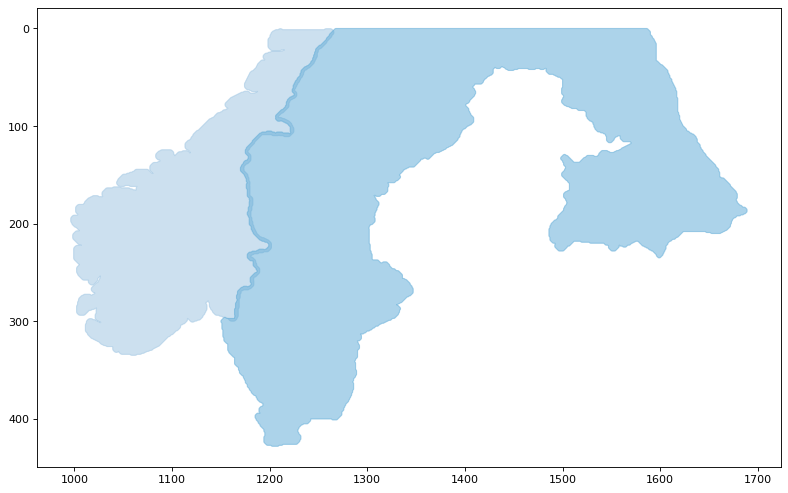

TypeError: must be real number, not tuple

In [32]:
from shapely.geometry import MultiPolygon, MultiLineString, MultiPoint, Point, GeometryCollection, LinearRing
import shapely.affinity
import shapely.ops
import copy
import shapely.wkt

def middlePoint(pta, ptb):
    pts = np.array([pta.coords, ptb.coords]).reshape((2,2))
    return tuple((pts[0]+pts[1])/2)

def is_consistent_middle_point(point, sega, segb, intersection, existing_segment):
    dista = sega.distance(point)
    distb = segb.distance(point)
    try :
        ratio = min(dista, distb)/(dista+distb)
        if ratio < .4:
            return False
    except ZeroDivisionError:
        pass
    if not point.intersects(intersection):
        return False
    if len(existing_segment) > 2:
        print('existing : ', existing_segment)
        print('existing linestring : ', LineString(existing_segment))
        print('exsiting plus point coords', existing_segment + [)
        if not LineString(existing_segment + [point.coords]).is_simple :
            return False
    return True

def linkPoints(midA, midB):
    midA = np.array(midA)
    midB=np.array(midB)
    currentPt = midA[0]
    assert all(midA[0]==midB[0])
    
    ia,ib=0,0
    res = []
    while ia < len(midA) and ib < len(midB) :
        if ia==len(midA):
            currentPt = midB[ib]
            ib+=1
        elif ib==len(midB):
            currentPt = midA[ia]
            ia+=1
        else:
            distA = np.linalg.norm(currentPt- midA[ia])
            distB = np.linalg.norm(currentPt- midB[ib])
            if distA <= distB: 
                currentPt = midA[ia]
                ia+=1
            else:
                currentPt = midB[ib]
                ib+=1
        res.append(currentPt)
    res = LineString(res)
    return res

def extend_lineString(to_extend, distance):
    while to_extend.coords[0]==to_extend.coords[1]:
        to_extend = LineString(to_extend.coords[1:])
    while to_extend.coords[-2]==to_extend.coords[-1]:
        to_extend = LineString(to_extend.coords[:-1])
    vector_at_start = np.array(to_extend.coords[1]) - np.array(to_extend.coords[0])
    vector_at_end = np.array(to_extend.coords[-2]) - np.array(to_extend.coords[-1])
    vector_at_start = vector_at_start/ np.linalg.norm(vector_at_start)
    vector_at_end = vector_at_end/ np.linalg.norm(vector_at_end)
    further_start = to_extend.coords[0] - vector_at_start*distance
    further_end = to_extend.coords[-1] - vector_at_end*distance
    res = LineString([further_start]+list(to_extend.coords)+[further_end])
    return res
def get_points_close_each_other(point_group):
    assert isinstance(point_group, MultiPoint)
    for point in point_group:
        close_points = [p for p in point_group if p != point and p.distance(point) < .5]
        if len(close_points):
            return MultiPoint([point] + close_points)

def save_polygons(names, polygons):
    for i, name in enumerate(names):
        with open(f'{name}.wkt', 'w') as f:
            f.write(shapely.wkt.dumps(polygons[i]))
            
def get_extremities_of_intersection(pola, polb, intersection):
    #intersection is lightly buffered due to precision problems which made it too small  by 1e-13 pt in a few cases
    extremities = polb.boundary.intersection(pola.boundary).intersection(intersection.buffer(1e-3))
    if isinstance(extremities, Point):
        save_polygons(['pola', 'polb', 'intersection'], [pola, polb, intersection])
        drawPaul((pola, 'blue'), (polb, 'red'), (intersection, 'y'), (extremities, 'black'))
        print(extremities)
        raise DonutException('Less than 2 extremities, probably donut')
    if isinstance(extremities, GeometryCollection) or isinstance(extremities, MultiLineString) :
        print('transformed geometry collection to multipoint, initial extremities : ', extremities)
        extremities = GeometryCollection([geom for geom in extremities if (isinstance(geom, Point) or (isinstance(geom, LineString) and geom.length < 1e-10))])
        print('filtered for linestring and points : ', extremities)
        extremities = MultiPoint([(geom if isinstance(geom, Point) else Point(geom.coords[0])) for geom in extremities ])
        print('as multipoint : ', extremities)
    if isinstance(extremities, LineString):
        print('extremities is only linestring : ', extremities)
        print('intersection : ', intersection)
        save_polygons(['pola', 'polb', 'intersection'], [pola, polb, intersection])
        raise Exception('extremities is only linestring')
    if len(extremities) < 2:
        print('Error : only one or zero extremity')
        print('extremities : ', extremities)
        save_polygons(['polygon_to_cut', 'polb', 'intersection'], [pola, polb, intersection])
        print('extremities', extremities)
        drawPaul((pola, 'blue'), (polb, 'red'), (intersection, 'y'), (extremities, 'black'))
        raise Exception('Error only one extremity')
    # For when there are exactly 3 extremities, assumes 2 of them are very close
    if len(extremities) == 3:
        points_close = get_points_close_each_other(extremities)
        extremities = MultiPoint([pt for pt in extremities if pt != points_close[0]])
    try : 
        assert isinstance(extremities, MultiPoint)
    except AssertionError as e:
        print('Extremities is not multipoint : ', extremities)
        raise e
    assert len(extremities)==2
    try :
        assert extremities.geoms[0].distance(extremities.geoms[1]) > 1e-10    
    except AssertionError:
        #print('initial extremities : ', polb.boundary.intersection(pola.boundary).intersection(intersection.buffer(1e-10)))
        print('once filtered : ', extremities)
        raise Exception('Extremities are too close together, intersection area : ', intersection.area)
    if not all(extremity.intersects(intersection.boundary) for extremity in extremities):
        for pt in extremities:
            if not pt.intersects(intersection.boundary):
                min_dist = min(pt.distance(Point(bd_point)) for bd_point in intersection.boundary.coords)
                closest = next(Point(bd_coord) for bd_coord in intersection.boundary.coords if Point(bd_coord).distance(pt) == min_dist)
                extremities = MultiPoint([closest] + [extremity for extremity in extremities if extremity != pt] )

    return extremities
'''
Creates two segment facing each other from a linearring split along 2 extremities
The start of the first linear is the same as the second, the ends of both segments are also the same point

'''
def split_polygon_perimeter(intersection_boundary, extremities):
    assert isinstance(extremities, MultiPoint)
    assert len(extremities) is 2
    assert isinstance(intersection_boundary, LineString)
    splitted = shapely.ops.split(intersection_boundary, extremities[0])
    if len(splitted) > 2:
        raise Exception(f'splitted is size {len(splitted)}')
    elif len(splitted)==2:
        # Making the line string begin at extremities[0] to get a perfect cut
        splitted = LineString(list(splitted[1].coords) + list(splitted[0].coords))
    else:
        splitted = splitted[0]
    try :
        splitted = shapely.ops.split(splitted, extremities)
    except ValueError as e :
        print(splitted)
        raise e
    if len(splitted) != 2:
        drawPaul((polygon_to_cut, 'blue'), (polb, 'yellow'), (intersection.boundary, 'green'), (extremities, 'red'))
        print('extremities bounds : ', extremities.bounds)
        print('intersection bounds : ', intersection.bounds)
        print('extremity 0 intersects : ', extremities[0].intersects(intersection.boundary))
        print('extremity 1 intersects : ', extremities[1].intersects(intersection.boundary))
        print('extremity 1 distance : ', extremities[1].distance(intersection.boundary))
        print(f'Splitted is size {len(splitted)} after cut with {len(extremities)} extremities : {extremities}')
        print(f'''
            Validity : 
            polygon_to_cut : {polygon_to_cut.is_valid}
            polb : {polb.is_valid}
            intersection : {intersection.is_valid}
        ''')
        raise Exception()
    ordered = LineString(splitted[1].coords[::-1])
    assert ordered.coords[0] == splitted[0].coords[0]
    # a simplifier sega, segb = splitted0, ordered
    segA, segB = (splitted[0], ordered) if len(splitted[0].coords) > len(ordered.coords) else (ordered, splitted[0])
    return segA, segB
    
def compute_border_middle(polygon_to_cut, polb, intersection):
    extremities = get_extremities_of_intersection(polygon_to_cut, polb, intersection)
    # To be extracted to 'split polygon_perimeter'
    segA, segB = split_polygon_perimeter(intersection.boundary, extremities)
    #End of 'split_polygon_perimeter'
    
    nbPtA, nbPtB = len(segA.coords), len(segB.coords)
    midSegA = []
    for i in range(nbPtA):
        pta = Point(segA.coords[i])
        ptb = segB.interpolate(segB.project(pta))
        middle_point = middlePoint(pta, ptb)
        if is_consistent_middle_point(Point(middle_point), segA, segB, intersection, midSegA):
            midSegA.append(middle_point)
    midSegB = []
    for i in range(nbPtB):
        ptb = Point(segB.coords[i])
        pta = segA.interpolate(segA.project(ptb))
        middle_point = middlePoint(pta, ptb)
        if is_consistent_middle_point(Point(middle_point), segA, segB, intersection, midSegB):
            midSegB.append(middle_point)
    #print('mida', midSegA, 'midb', midSegB)
    #drawPaul((polygon_to_cut, 'blue'), (LineString(midSegA), 'yellow'), (LineString(midSegB), 'red'))
    midSeg = linkPoints(midSegA, midSegB)
    if not midSeg.is_simple:
        midSeg = midSegA
    midSeg = LineString(midSeg)
    try :
        assert midSeg.is_simple
    except AssertionError as e:
        save_polygons(['pola', 'polb', 'intersection', 'midSeg'], [polygon_to_cut, polb, intersection, midSeg])
        raise e
    midSeg = extend_lineString(midSeg, 1e-3)
    midSeg = ensure_seg_extremities_out_of_polygon(midSeg, polygon_to_cut)
    return midSeg

def move_randomly(point, delta):
    return shapely.affinity.translate(point, (2*random.random()-1)*delta, (2*random.random()-1)*delta)

def make_point_exit_polygon(point, polygon):
    for i in range(1000):
        translated = move_randomly(point, 1e-3)
        if not translated.within(polygon):
            return translated
    raise Exception('Point is too far in the polygon to be moved outside')

def ensure_seg_extremities_out_of_polygon(segment, polygon):
    start, end = Point(segment.coords[0]), Point(segment.coords[-1])
    if start.within(polygon):
        #print('start within polytgon')
        #drawPaul((start, 'red'), (polygon, 'blue'), (segment, 'black'))
        start = make_point_exit_polygon(start, polygon)
        segment = LineString([start.coords[0]]+segment.coords[1:])
        #print('made it go out')
        #drawPaul((start, 'red'), (polygon, 'blue'), (segment, 'black'))
    if end.within(polygon):
        #print('end within polygon')
        #drawPaul((end, 'red'), (polygon, 'blue'), (segment, 'black'))
        end = make_point_exit_polygon(end, polygon)
        segment = LineString(segment.coords[:-1]+[end.coords[0]])
        #print('made it go out')
        #drawPaul((end, 'red'), (polygon, 'blue'), (segment, 'black'))
    return segment

def get_polygon_cut_on_border_middle(polygon_to_cut, border_middle):
    assert isinstance(polygon_to_cut, Polygon)
    assert isinstance(border_middle, LineString)
    polygon_split = shapely.ops.split(polygon_to_cut,border_middle)
    #drawPaul((polygon_split[0], 'gray'), (polygon_split[1], 'blue'), (border_middle, 'black'))
    try:
        assert len(polygon_split)>=2
    except AssertionError as e:
        drawPaul((polygon_to_cut, 'blue'), (border_middle, 'black'))
        raise e
    polygon_cut = next(part for part in polygon_split if part.area==max([pol.area for pol in polygon_split]))
    assert polygon_cut.area==max([pol.area for pol in polygon_split])
    return polygon_cut

def reduce_conflict_by_middle_border(to_be_reduced_polygon, conflicting_polygon):
    assert isinstance(to_be_reduced_polygon, Polygon)
    assert isinstance(conflicting_polygon, Polygon)
    #drawPaul((to_be_reduced_polygon, 'blue'), (conflicting_polygon, 'red'))
    intersections = to_be_reduced_polygon.intersection(conflicting_polygon)
    if isinstance(intersections, GeometryCollection):
        intersections = MultiPolygon([p for p in intersections if isinstance(p, Polygon)])
        # asserts the conflict makes polygons (because it should not be only shared line border, which is ok)
        assert len(intersections)
    if not isinstance(intersections, Polygon) and not isinstance(intersections, MultiPolygon):
        print(intersections)
        raise Exception('The intersection with the conflict is no polygon')
        
    if not isinstance(intersections, MultiPolygon):
        intersections=MultiPolygon([intersections])
    for intersection in intersections:
        if intersection.area < 1e-3 :
            to_be_reduced_polygon = to_be_reduced_polygon.difference(intersection)
        else :
            border_middle = compute_border_middle(to_be_reduced_polygon, conflicting_polygon, intersection)
            to_be_reduced_polygon = get_polygon_cut_on_border_middle(to_be_reduced_polygon, border_middle)
    return to_be_reduced_polygon

def reduce_territory(dilated_territory, other_dilated_territories, already_reduced_territories):
    conflicting_territories = [t for t in other_dilated_territories if t.polygon.intersects(dilated_territory.polygon)]
    if conflicting_territories and False:
        drawPaul(dilated_territory, *conflicting_territories)
    for conflict in tqdm(conflicting_territories[8:], leave=False):
        if conflict in already_reduced_territories:
            dilated_territory.polygon = dilated_territory.polygon.difference(conflict.polygon)
            assert isinstance(dilated_territory.polygon, Polygon)
        else:
            try:
                dilated_territory.polygon = reduce_conflict_by_middle_border(dilated_territory.polygon, conflict.polygon)
            except Exception as e:
                drawPaul(dilated_territory, conflict)
                raise e

def remove_contained_territories(dilated_territories):
    return [terr for terr in dilated_territories 
            if not any(t.polygon.contains(terr.polygon) for t in 
                       [other for other in dilated_territories if other != terr and other.contemporary_with(terr)])]
from time import time
def solve_border_conflicts(dilated_territories):
    init_size = len(dilated_territories)
    dilated_territories = remove_contained_territories(copy.deepcopy(dilated_territories))
    print(f'removed {init_size - len(dilated_territories)} that were contained')
    handled_territories = []
    for territory in tqdm(dilated_territories[17:]):
        other_dilated = [t for t in dilated_territories if t != territory and territory.contemporary_with(t)]
        reduce_territory(territory, other_dilated, handled_territories)
        handled_territories.append(territory)
    return handled_territories
#drawPaul(*europe_fat[:10],  simplify=True)
europe_nice = solve_border_conflicts(europe_fat)

In [ ]:
drawPaul(*europe_nice, *[(LineString(t.polygon.exterior.coords), [0,0,0]) for t in europe_nice])

intersection bounds :  (1170.003137254902, 117.1155008472859, 1181.05920928287, 152.44647324512232)
pola bounds (996.2, 0.2000000000000002, 1265.0987749827746, 334.8)
polb bounds (1150.003137254902, 0.0031372549019606, 1688.996862745098, 427.99686274509804)
once cut with intersection :  POINT (1175.055667256624 152.4464732451223)
once cut with buffered intersection :  MULTIPOINT (1175.055667256624 152.4464732451223, 1181.05920928287 117.1155008472859)


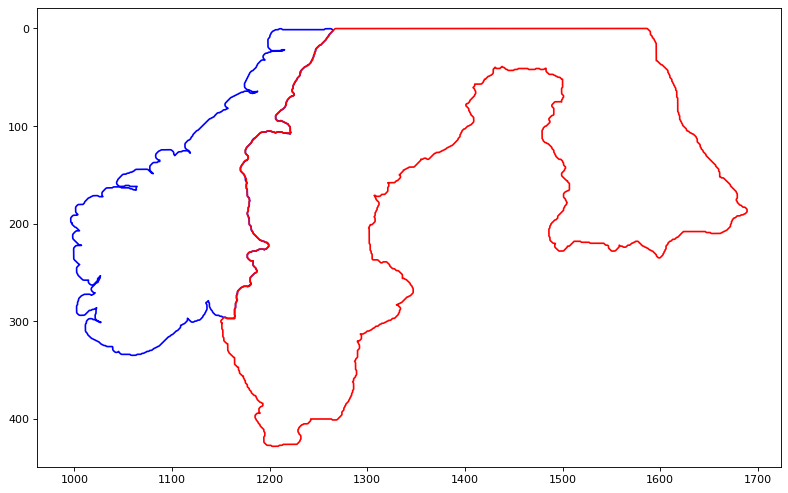

intersection of pola and polb boundary :  GEOMETRYCOLLECTION (POINT (1156.960496567783 297.003137254902), POINT (1166.103206898172 279.3800816845718), POINT (1166.16919744505 273.2054147750975), POINT (1167.003137254902 271.2447760944379), POINT (1175.055667256624 152.4464732451223), POINT (1176.558107988826 264.0836303042259), POINT (1176.885731119683 164.7110209895272), POINT (1178.201136439495 192.8621145549334), POINT (1179.003137254902 194.7679907097936), POINT (1180.175082671963 259.8070284917435), POINT (1181.05920928287 117.1155008472859), POINT (1182.304395533128 208.0514076082043), POINT (1185.120541620955 112.0541685092003), POINT (1192.100421349057 106.2188556372676), POINT (1216.364088573746 78.85655709901187), POINT (1217.130165236483 75.30509861945572), POINT (1220.930960037345 70.31496395967216), POINT (1223.538748655304 69.05936897786347), POINT (1231.061697651319 46.52945206974891), POINT (1232.267235799395 43.01058966203567), POINT (1237.930960037344 38.3149639596723

In [15]:
with open('pola.wkt', 'r') as f:
    polygon_to_cut_pb = shapely.wkt.loads(f.read())
with open('intersection.wkt', 'r') as f:
    intersection_pb = shapely.wkt.loads(f.read())
with open('polb.wkt', 'r') as f:
    polb_pb = shapely.wkt.loads(f.read())
with open('midSeg.wkt', 'r') as f:
    midSeg_pb = shapely.wkt.loads(f.read())
    
def _innerDrawPaul(obj, i , color=None, simplify=None):
    try :
        if isinstance(obj, Polygon) or isinstance(obj, LineString):
            if simplify:
                obj=obj.simplify(1)
            color =  color if color is not None else [ 'g', 'r', 'c', 'm', 'y', 'k'][i%6]
        if isinstance(obj, Polygon):
            plt.fill(*obj.exterior.xy, color=color, alpha=.5)
        elif isinstance(obj, LineString):
            if obj.length:
                plt.plot(*obj.xy, color=color)
        elif isinstance(obj, tuple):
            _innerDrawPaul(obj[0], i, obj[1], simplify)
        elif isinstance(obj, Territory):
            _innerDrawPaul(obj.polygon, i, obj.color, simplify)
        elif isinstance(obj, MultiPolygon):
            _innerDrawPaul(GeometryCollection(obj.geoms), color, simplify)
        elif isinstance(obj, Point):
            _innerDrawPaul(obj.buffer(.1), i, color, simplify)
        elif isinstance(obj, MultiPoint):
            _innerDrawPaul(obj.buffer(.1), i, color, simplify)
        elif isinstance(obj, GeometryCollection):
            for sub_object in obj:
                _innerDrawPaul(sub_object, i, color, simplify)
        else:
            raise TypeError(f'Unknown type : {type(obj)}')
    except Exception as e :
        print('Error plotting : ', obj)
        raise e

def drawPaul(*objects, simplify=False):
    ax = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k').add_subplot()
    ax.set_aspect(aspect='equal')
    for i, o in tqdm(enumerate(objects),total=len(objects), leave=False):
        _innerDrawPaul(o, i, simplify=simplify)
    plt.gca().invert_yaxis()
    
    plt.show()
extremities = polb_pb.boundary.intersection(polygon_to_cut_pb.boundary).intersection(intersection_pb.buffer(1e-10))
extremities_wthout_intersection = polb_pb.boundary.intersection(polygon_to_cut_pb.boundary)
#print('len extremities without intersection ; ', len(extremities_wthout_intersection))
print('intersection bounds : ', intersection_pb.bounds)
print('pola bounds', polygon_to_cut_pb.bounds)
print('polb bounds', polb_pb.bounds)
print('once cut with intersection : ', extremities_wthout_intersection.intersection(intersection_pb))
print('once cut with buffered intersection : ', extremities_wthout_intersection.intersection(intersection_pb.buffer(1e-3)))
drawPaul((polygon_to_cut_pb.boundary, 'blue'), (intersection_pb, 'yellow'),(extremities_wthout_intersection, 'green'), (polb_pb.boundary, 'red'), (extremities, 'black'))
print('intersection of pola and polb boundary : ', extremities_wthout_intersection)
print('intersection of pola and polb lying in yellow area', extremities)

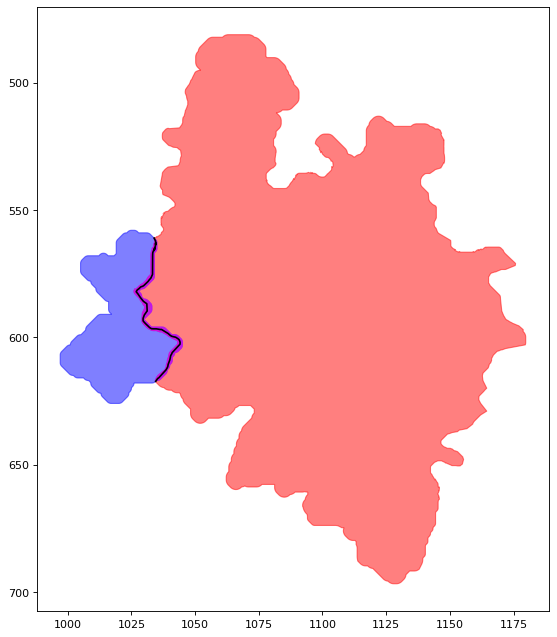

In [24]:
with open('pola.wkt', 'r') as f:
    polygon_to_cut_pb = shapely.wkt.loads(f.read())
with open('intersection.wkt', 'r') as f:
    intersection_pb = shapely.wkt.loads(f.read())
with open('polb.wkt', 'r') as f:
    polb_pb = shapely.wkt.loads(f.read())
with open('midSeg.wkt', 'r') as f:
    midSeg_pb = shapely.wkt.loads(f.read())
    
drawPaul((polygon_to_cut_pb, 'red'), (polb_pb, 'blue'), (intersection_pb, 'magenta'), (midSeg_pb, 'black'))